# Quantum Kernel Estimator Challenge

For the first leg of the QML challenge, you implemented a variational quantum classifier (VQC) to take on a supervised learning problem based on the work of [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). Now, you will build on that experience, and explore Havlicek et al.'s second proposed method of applying quantum-enhanced feature spaces to machine learning: the *quantum kernel estimator*. In this challenge continuation, you will construct a QML model that estimates a kernel function using a quantum computer and optimize a classical support vector machine (SVM). For this classification protocol, we will continue to restrict ourselves to the binary label case, with $C = \left\{+1, −1\right\}$.

Compared to the VQC challenge, we are providing very little template code for this kernel estimator challenge. This is by design to enable teams to further differentiate their model, especially in the training phase. The [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf) paper is your best resource, and the [Kernel-based training Pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html) may also be helpful. You are free to import and use any additional packages that you wish.

In [201]:
!qbraid jobs enable haqs  # enable quantum jobs

You have already enabled qBraid Quantum Jobs in the haqs environment.


In [202]:
TEAM_NAME = "Feynman-Prodigies"  # enter team name

In [203]:
!pip install cvxopt

In [204]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from scipy.optimize import minimize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from cvxopt import matrix, solvers

## Load and visualize dataset

As before, we are given data from a training set $T$ and a test set $S$ of a subset $\Omega \in \rm {I\!R}^n$. Both are assumed to be labelled by the map $m: T \cup S \rightarrow \{+1, −1\}$ unkown to the algorithm. To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

In [343]:
# %run gen_binary.py  # uncomment to generate new train/test dataset

In [205]:
DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_sets = 2
samples_per_set = 40
n_samples = n_sets * samples_per_set
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, train_size=1 / n_sets
)

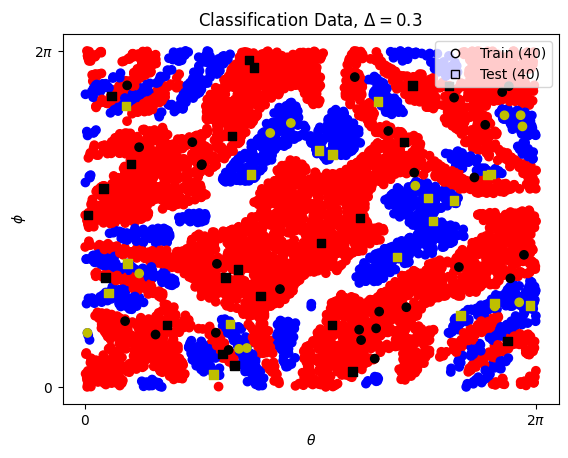

In [206]:
split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.show()

An arbitrary single qubit state can be written:

$$ \left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle + e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere.

In [207]:
def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

In [208]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

Considering only Ising type interactions ($d=2$), the unitaries are generated from one- and two- big gates of the form

$$U_{\phi_{\{k\}}(\textbf{x})} = \exp\big(i\phi_{\{k\}}(\textbf{x})Z_k \big)$$
$$U_{\phi_{\{l,m\}}(\textbf{x})} = \exp\big(i\phi_{\{k,l\}}(\textbf{x})Z_kZ_l\big)$$

where we have followed Havlíček et al. and chosen $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

In [209]:
n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
pset = powerset(range(n_wires), S_size)

In [210]:
pset

[(0, 1)]

In [211]:
X_train.shape

(40, 2)

In [212]:
X_train[0],encode_data(X_train[0])

(tensor([4.09639341, 1.40912563], requires_grad=True),
 (tensor(4.09639341, requires_grad=True),
  tensor(1.40912563, requires_grad=True),
  tensor(-1.65416082, requires_grad=True)))

In [213]:
def embedding(x):
    """The embedding ansatz

    Args:
        x : shape (3,) tensor containing one encoded data vector

    """
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
        qml.RZ(-2 * x[wire], wires=wire)
    for s in pset:
        qml.CNOT(wires=s)
        qml.RZ(-2 * x[2], wires=1)
        qml.CNOT(wires=s)

## Quantum kernel (ideal)

In [218]:
dev_kernel = qml.device("default.qubit", wires=n_wires)

projector = np.zeros((2**n_wires, 2**n_wires))
projector[0, 0] = 1


@qml.qnode(dev_kernel)
def kernel(x, z):
    """Compute quantum kernel element for two feature vectors.

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    """

    x_enc = encode_data(x)
    z_enc = encode_data(z)

    for _ in range(S_size):
        embedding(x_enc)

    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)

    return qml.expval(qml.Hermitian(projector, wires=range(n_wires)))

In [219]:
kernel(X_train[1],X_train[1])

tensor(1., requires_grad=True)

In [220]:
def kernel_ideal(A, B):
    """Ideal kernel matrix for sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

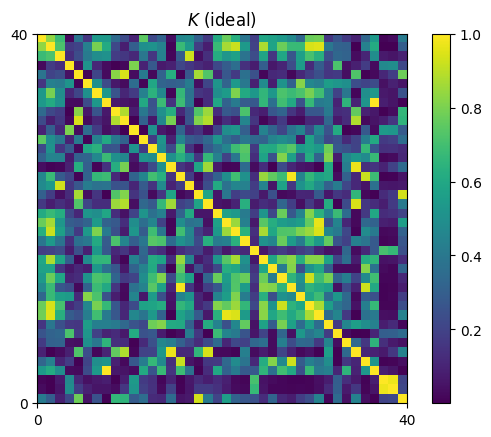

In [221]:
# Visualize ideal kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (right)

k_ideal = kernel_ideal(X_train, X_train)

im = plt.imshow(k_ideal, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$K$ (ideal)")
plt.show()

## Quantum kernel estimator

Here it will be convenient to write $T = \left\{\textbf{x}_1,...,\textbf{x}_t\right\}$ with $t = \left|T\right|$; also let $y_i = m(\textbf{x}_i)$ be the corresponding label. In this protocol you will use a quantum computer to estimate the $t \times t$ kernel matrix $K(\textbf{x}_i, \textbf{x}_j) = \left|\langle\Phi(\textbf{x}_i)|\Phi(\textbf{x}_j)\rangle\right|^2$. For all pairs of points $\textbf{x}_i, \textbf{x}_j \in T$ in the the training data, you will sample the overlap between feature states to obtain the matrix entry in the kernel. This fidelity can be estimated from the output probability of the circuit by sampling the output distribution with $R$ shots and only taking the $0^n$ count. The frequency of the $0^n$ count is an estimator of the Kernel entry up to an error $\epsilon = O(R^{−1/2})$. After the kernel matrix for the full training data has been constructed we use the conventional (classical) support vector machine classifier. The optimal hyperplane can be found by solving the dual quadratic program $L_D$ for the variables $\alpha = \left\{\alpha_i\right\}_{i=1...t}$. Hence, to train, we maximize

\begin{equation}
L_D(\alpha) = \sum_{i=1}^t \alpha_i - \frac{1}{2} \sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\textbf{x}_i, \textbf{x}_j),
\label{eq:Ld} \tag{1}
\end{equation}

subject to $\sum_{i=1}^t \alpha_i y_i = 0$ and $\alpha_i \geq 0$. This problem is concave, and therefore efficiently solvable, whenever $K(\textbf{x}_i, \textbf{x}_j)$ is a positive definite matrix. Standard quadratic programming solvers can be used. The solution to this problem will be given by a nonnegative vector $\alpha^* = (\alpha_1^*,...,\alpha_t^*)$. Due to complementary slackness, we expect that many of the $\alpha_i^*$ will be zero. Hence, there will only be subset of training samples that are needed to construct the optimal hyperplane. These samples are referred to as the support vectors.

The training phase consists of the following steps:

---
### Algorithm 1: training
1. **Input** Labeled training samples $T = \left\{ \textbf{x} \in \Omega \in {\rm I\!R}^n \right\} \times \left\{ y \in C \right\}$, quadratic program solver.
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ **do**
5. $\hspace{5mm}$ **for** $\textit{j} = 1$ to $\textit{t}$ **do**
6. $\hspace{10mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{10mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{15mm}$ Run the circuit from Havlicek Fig. 2.c. with paremeters $\textbf{x}_i, \textbf{x}_j$.
9. $\hspace{15mm}$ Measure outcome in $Z$-basis.
10. $\hspace{15mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{20mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{15mm}$ **end if**
13. $\hspace{10mm}$ **end for**
14. $\hspace{10mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{x}_j) = r_{0^n}R^{-1}$.
15. $\hspace{5mm}$ **end for**
16. **end for**
17. Use quadratic program solver to optimize $\alpha$ in $L_D$ in eqn. (1) with kernel $K = \hat{K}$ and set $T$.
18. **return** the final parameters $\alpha^*$ and value of the cost function $L_D$ and kernel estimator $\hat{K}$.
---

In [222]:
shots = 5000

dev_est = qml.device("default.qubit", wires=n_wires, shots=shots)


@qml.qnode(dev_est)
def fidelity_estimate(x, z):
    """Directly estimate the fidelity between a pair of feature vectors for data `x` and `z`

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    Returns:
        shape (2, `R`) tensor containing `R` Z-basis measurement samples on each qubit, where `R` 
        is the number of shots determined from the dev.shots attribute of the corresponding device.
    """
    x_enc=encode_data(x)
    z_enc=encode_data(z)

    for _ in range(S_size):
        embedding(x_enc)

    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)    

    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))

In [223]:
#To check if shape is as expected
ex=fidelity_estimate(X_train[1],X_train[1])
ex.shape

(2, 5000)

In [224]:
#Check if fidelity_estimate(X_train[1],X_train[1]) gives 1
r=0
for i in range(len(ex[0])):
    if (ex[0][i]) == 1 and (ex[1][i]) == 1:
        r+=1
print(r/shots)

1.0


In [225]:
def kernel_calculator(A,B):
    fidelity_est=fidelity_estimate(A,B)
    r=0
    for i in range(shots):
        if (fidelity_est[0][i]) == 1 and (fidelity_est[1][i]) == 1:
            r+=1
    return(r/shots) #r/R, R is number of shots

In [226]:
def kernel_experimental(A, B):
    """Experimental kernel matrix for sets A and B."""
    return np.array([[kernel_calculator(a, b) for b in B] for a in A])

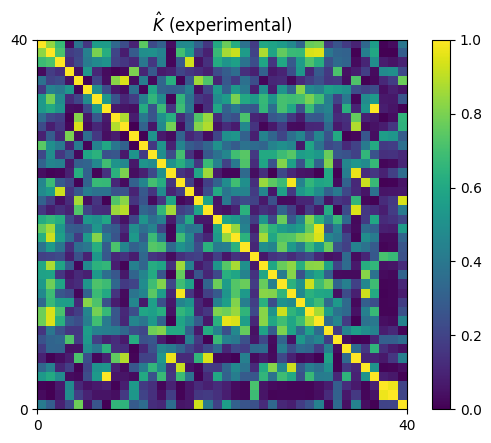

In [227]:
# Visualize experimental kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (left)

k_experimental_calc = kernel_experimental(X_train, X_train)

im = plt.imshow(k_experimental_calc, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\hat{K}$ (experimental)")
plt.show()

In [228]:
m, n = X_train.shape
# ker_ide=kernel_ideal(X_train,X_train)
K =k_experimental_calc #already calculated  ker_ide#
y=Y_train.reshape(-1,1) * 1

In [159]:
C=shots*10 #rule of thumb
P = matrix(K.T.dot(K))
q = matrix(-1 * np.ones(m))         
G = matrix(np.concatenate((-1*np.identity(m), np.identity(m)), axis=0))
h = matrix(np.concatenate((np.zeros(m), C*np.ones(m)), axis=0))
A = matrix(1.0 * y, (1, m))
b = matrix(0.0)

In [160]:
solution = solvers.qp(P,q,G,h,A,b)
alphas = np.array(solution['x'])
ind = (alphas > np.median(np.array(solution['x']))).flatten()#(alphas > 1e-4).flatten()# #selecting alphas greater than median
sv = X_train[ind]
sv_y = Y_train[ind]
alphas = alphas[ind]

     pcost       dcost       gap    pres   dres
 0:  4.4722e+08 -1.0526e+10  2e+10  1e-01  2e-11
 1:  2.9646e+08 -6.2428e+08  1e+09  3e-03  1e-09
 2:  5.7833e+07 -6.2010e+07  1e+08  1e-05  1e-11
 3:  8.3198e+06 -9.2019e+06  2e+07  7e-14  7e-12
 4:  1.1922e+06 -1.3122e+06  3e+06  5e-14  2e-12
 5:  1.7075e+05 -1.8809e+05  4e+05  3e-14  9e-13
 6:  2.4431e+04 -2.6984e+04  5e+04  2e-14  4e-13
 7:  3.4864e+03 -3.8811e+03  7e+03  3e-15  1e-13
 8:  4.9401e+02 -5.6170e+02  1e+03  4e-15  6e-14
 9:  6.8628e+01 -8.2630e+01  2e+02  3e-16  2e-14
10:  8.9621e+00 -1.2686e+01  2e+01  2e-16  8e-15
11:  8.9656e-01 -2.1772e+00  3e+00  2e-16  3e-15
12: -8.5484e-02 -4.9624e-01  4e-01  2e-16  1e-15
13: -1.7928e-01 -2.5735e-01  8e-02  2e-16  4e-16
14: -2.0696e-01 -2.2834e-01  2e-02  1e-16  2e-16
15: -2.1808e-01 -2.2222e-01  4e-03  2e-16  1e-16
16: -2.2022e-01 -2.2052e-01  3e-04  2e-16  2e-16
17: -2.2036e-01 -2.2037e-01  1e-05  2e-16  2e-16
18: -2.2036e-01 -2.2036e-01  6e-07  1e-16  2e-16
19: -2.2036e-01 -2.20

In [291]:
# bias=0
# for i in range(len(sv)):
#     b= sv_y[i]- np.sum(np.matmul((kernel_experimental(X_train,[sv[i]])),(sv_y[i]*alphas[i])), axis=0)
#     bias+=b
# bias_fin=bias/len(sv)

In [161]:
support_vec_ker=kernel_experimental(sv, sv) #kernel_ideal(sv,sv)#

In [162]:
b = -0.5*(sv_y - np.sum(support_vec_ker * alphas * sv_y, axis=0))

In [196]:
sel=np.argmin(np.array(solution['x']))

In [199]:
b=Y_train[sel]- np.sum(np.multiply(np.multiply(Y_train,np.array(solution['x'])),(K[:,sel])))
b

tensor(-3.4801546, requires_grad=True)

In [ ]:
# bias= np.sum(bias) / bias.size
# bias

In [ ]:
 # bias_fin

In [163]:
bias=np.median(b)/b.size
bias

tensor(-0.02143609, requires_grad=True)

In [168]:
(sv_y * alphas).shape

(20, 20)

In [177]:
weights=np.sum(((sv_y * alphas).dot(sv)),axis=1)

In [178]:
weights_fin=weights.T
weights_fin

tensor([1.58256930e+00, 2.57739830e-08, 1.80793865e+00, 1.04871650e-07,
        3.29485575e-07, 2.75957177e-09, 1.48445904e+00, 2.40590373e-09,
        4.03510487e-09, 3.94921150e-01, 2.48213465e-09, 7.79944243e-01,
        2.82011541e-09, 5.35252455e-01, 1.91033340e-09, 2.78025273e-09,
        1.93096767e-09, 7.17695017e-09, 2.38060078e-09, 2.89727759e-04], requires_grad=True)

In [585]:
# bias = -0.5*(np.sum(b) / b.size) #b around 0.06
# bias

tensor(-0.13357926, requires_grad=True)

In [70]:
train_ker=kernel_experimental(sv,X_train) #kernel_ideal(sv,X_train)#

In [71]:
prod = np.sum(np.matmul((train_ker).T,(sv_y*alphas).T), axis=1) + bias
predictions = np.sign(prod)

In [72]:
#train accuracy
accuracy_score(predictions,Y_train)

0.925

In [73]:
test_ker=kernel_experimental(sv,X_test) #kernel_ideal(sv,X_test)#

In [74]:
prod_test = np.sum(np.matmul((test_ker).T,(sv_y*alphas).T), axis=1) + bias
predictions_test = np.sign(prod_test)

In [75]:
#test accuracy
accuracy_score(predictions_test,Y_test)

0.975

In [57]:
_lambda = np.ravel(solution['x'])
# find support vectors
S = np.where((_lambda > 1e-4))[0]
w = K[:, S].dot(_lambda[S])
M = np.where((_lambda > 1e-4))[0]
b = np.mean(Y_train[M] - kernel_experimental(X_train[M],X_train).dot(w))

In [58]:
b

tensor(-0.81067123, requires_grad=True)

In [52]:
w

tensor([0.09644618, 0.07299221, 0.0575218 , 0.16121926, 0.0892318 ,
        0.068702  , 0.10127596, 0.09280369, 0.08813295, 0.12192789,
        0.06354742, 0.0641729 , 0.14621238, 0.10161341, 0.07930731,
        0.08461217, 0.05635344, 0.1221021 , 0.10459935, 0.10186875,
        0.12996534, 0.07798453, 0.16645154, 0.11358415, 0.11571664,
        0.07614444, 0.18798992, 0.07711417, 0.09414587, 0.1033294 ,
        0.0885584 , 0.10148371, 0.07491503, 0.07309718, 0.07279057,
        0.09911146, 0.14213791, 0.18840529, 0.14113409, 0.06114088], requires_grad=True)

In [648]:
ker_train=(kernel_experimental(X_train[M],X_train))

In [662]:
predictions.shape

(40,)

In [661]:
prod =np.sum(((ker_train).T*(Y_train[M]*_lambda[S])),axis=1) + b
# prod[prod == 0] = 1
predictions = np.sign(prod)

In [647]:
(kernel_experimental(X_train[M],X_train)).T

tensor(-1., requires_grad=True)

In [663]:
accuracy_score(predictions,Y_train)

0.35

In [553]:
_lambda=np.array(solution['x'])
max_support_vector = _lambda.max()
tolerance = max_support_vector * 1e-3  # All alphas that are withing 3 orders of magnitude of the the maximum
support_vectors = ~np.isclose(_lambda, 0, atol=tolerance).ravel()
n_support_vectors = np.count_nonzero(support_vectors)
w = (_lambda[support_vectors] * K[support_vectors]).sum(axis=0)
ind_1=(y==1).flatten()
ind_minus_1=(y==-1).flatten()
b = - 0.5 * (np.max(K[ind_1] @ w) + np.min(K[ind_minus_1] @ w))

In [571]:
np.sign(train_ker @ w + b/1.15)

tensor([-1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
         1.,  1., -1.,  1.,  1.,  1.,  1.], requires_grad=True)

In [ ]:
#train 0.95, test 0.925

In [235]:
# Note that SVC expects the kernel argument to be a kernel matrix function & high C decreases the impact of regularization
#As rule of thumb kept it as equal to number of shots
svm_trained = SVC(kernel=kernel_experimental,C=shots*10).fit(X_train, Y_train)  # kernel_ideal

In the classification phase, we want to assign a label to a new datum $s \in S$ of the test set. For this, the inner products $K(\textbf{x}_i, \textbf{s})$ between all support vectors $\textbf{x}_j \in T$ with $\alpha_i^* > 0$ and the new datum s have to be estimated on the quantum computer, c.f. Havlicek Fig. S5.b. The new label $\tilde{m}(\textbf{s})$ for the datum is assigned according to Havlicek eqn. (14). Since all support vectors are known from the training phase and we have obtained access to the kernel $K(\textbf{x}_i,\textbf{s})$ from the quantum hardware, the label can be directly computed according to


\begin{equation}
\tilde{m}(\textbf{s}) = \text{sign} \bigg(\sum_{i=1}^t y_i \alpha_i^* K(\textbf{x}_i, \textbf{s}) + b \bigg).
\label{eq:ms} \tag{2}
\end{equation}

Note that the bias $b$ in $\tilde{m}(\textbf{s})$ can be calculated from the weights $\alpha_i^*$ by choosing any $i$ with $\alpha_i^* > 0$ and solving $\sum_j y_j \alpha_j^* K(\textbf{x}_j, \textbf{x}_i) + b = y_i$ for $b$.

---
### Algorithm 2: classification
1. **Input** An unlabeled sample from the test set $\textbf{s} \in S$, optimal SVM parameters $\alpha, b$ and training data set $T$. 
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ with $\alpha_i^* > 0$ **do**
5. $\hspace{5mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{5mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{10mm}$ Run the circuit from Havlicek Fig. 2.c. with paremeters $\textbf{x}_i, \textbf{s}$.
9. $\hspace{10mm}$ Measure outcome in $Z$-basis.
10. $\hspace{10mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{15mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{10mm}$ **end if**
13. $\hspace{5mm}$ **end for**
14. $\hspace{5mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{s}) = r_{0^n}R^{-1}$.
15. **end for**
16. **return** $\text{sign}\big(\sum_{i=1}^t y_i \alpha_i^* \hat{K}(\textbf{x}_i, \textbf{s}) + b \big)$.
---

In [236]:
#Predictions
predictions_test=svm_trained.predict(X_test)

In [237]:
#Train Accuracy
predictions=svm_trained.predict(X_train)
accuracy_trained=accuracy_score(predictions,Y_train)
print(f"The accuracy with the experimental kernel on train set is {accuracy_trained:.3f}")

The accuracy with the experimental kernel on train set is 1.000


In [238]:
#Test Accuracy #change from predictions to already predicted from test
# predictions_test=svm_trained.predict(X_test)
accuracy_test = accuracy_score(predictions_test, Y_test)
print(f"The accuracy with the experimental kernel on test set is {accuracy_test:.3f}")

The accuracy with the experimental kernel on test set is 1.000


In [529]:
#visualize test kernel
#store kernels and then use in quadratic program solver(to decrease time taken in calculating kernel)
#decrease shots to 5000 and see the impact
#how to use C

In [229]:
optimizer = SVC(kernel='precomputed',C=shots*10)
optimizer.fit(k_experimental_calc, Y_train)
supp_vec_indices = optimizer.support_
supp_vec_weights = optimizer.dual_coef_
bias = optimizer.intercept_

In [230]:
supp_vec_indices

array([ 8, 18, 33, 37, 38, 39,  0,  3,  5, 10, 11, 13, 31, 36],
      dtype=int32)

In [231]:
supp_vec_weights

array([[-0.34933902, -2.08249302, -2.54219777, -0.14910862, -1.33826528,
        -0.5420803 ,  0.15090608,  0.35719302,  1.16650923,  1.06688156,
         1.15339067,  1.66102912,  0.96561339,  0.48196093]])

In [232]:
bias

array([-0.07953582])

In [233]:
#Classification algorithm
def classifier(s):
    sum = 0 
    for i, index in enumerate(supp_vec_indices):
        kernel_estimate = kernel_calculator(X_train[index],s)
        sum += supp_vec_weights[0][i]*kernel_estimate + bias
    return np.sign(sum)

In [234]:
#Test accuracy
accuracy_count=0 
for i in range (40):
    if classifier(X_test[i]) == Y_test[i]:
        accuracy_count +=1
accuracy = accuracy_count/samples_per_set
print(accuracy)

0.75


In [179]:
indices_alphas=[]
for i,index in enumerate(ind):
    if index:
        indices_alphas.append(i)
indices_alphas

[3, 8, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 24, 26, 28, 31, 32, 36, 37, 39]

In [180]:
bias

tensor(-0.02143609, requires_grad=True)

In [181]:
weights_fin

tensor([1.58256930e+00, 2.57739830e-08, 1.80793865e+00, 1.04871650e-07,
        3.29485575e-07, 2.75957177e-09, 1.48445904e+00, 2.40590373e-09,
        4.03510487e-09, 3.94921150e-01, 2.48213465e-09, 7.79944243e-01,
        2.82011541e-09, 5.35252455e-01, 1.91033340e-09, 2.78025273e-09,
        1.93096767e-09, 7.17695017e-09, 2.38060078e-09, 2.89727759e-04], requires_grad=True)

In [184]:
#on above QP
def classifier(s):
    sum = 0 
    for i, index in enumerate(indices_alphas):
        kernel_estimate = kernel_calculator(X_train[index],s)
        sum += weights_fin[i]*kernel_estimate + bias
    return np.sign(sum)

In [185]:
#Test accuracy
accuracy_count=0 
for i in range (40):
    if classifier(X_test[i]) == Y_test[i]:
        accuracy_count +=1
accuracy = accuracy_count/40
print(accuracy)

0.6
